# Optimization Framework using auto-diff to optimize binding rates




## Import necessary modules

Every Jupyter Notebook requires the path to the KineticAssembly_AD modules (.py files in the root directory) to be mentioned. This can be done by adding the path to the 'PATH' variable of the system environment. 

Additonal modules are also imported which are required to run any analysis.

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
path_to_repo="C:\\Users\\denys\\AMGEN\\"      
#Insert your path here
# path_to_repo=""
sys.path.append(path_to_repo)

import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

## Setup Reaction Network
Before we begin to run the optimization routine, we need to create a Reaction Network that stores all the parameters required to run a simulation and other routines. The Reaction Network can be created by reading an input file. More information on how to create an input file can be found in the User Guide. 

Here a simple trimer model is used to run a simulation.
#### Read the corresponding input file and call the ReactionNetwork class

In [3]:
base_input = './trimer_homorates.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['default_assoc', 1.0]
['homo_rates', True]
[(0, {'struct': <networkx.classes.graph.Graph object at 0x000002A47F193198>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (1, {'struct': <networkx.classes.graph.Graph object at 0x000002A47F193320>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1}), (2, {'struct': <networkx.classes.graph.Graph object at 0x000002A47F193CF8>, 'copies': tensor([100.], dtype=torch.float64), 'subunits': 1})]
New node added - Node index: 3 ; Node label: AB 
New node added - Node index: 4 ; Node label: AC 
New node added - Node index: 5 ; Node label: BC 
New node added - Node index: 6 ; Node label: ABC 
Reaction Network Completed


## Checking reaction network

The ReactionNetwork is a networkx object which creates a graph network with each node as species that can be present in the system according to the binding rules given in the input file. Each node has a unique index number that can be used to access attributes stored for that species. Each edge represents a reaction and is associated with a unique reaction_id, on and off rates and the dG value for that reaction.


After creating a Reaction Network we can looping over all network nodes to check if all species are created
Creating a dictionary for later reference. This dictionary holds the reactants as keys and values as the reaction index

In [4]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr

print("Species present in the Reaction Network: ")
print("%3s  %2s  %2s" %("Index","--",'Species'))
for n in rn.network.nodes():
    print("%3d  %4s  %-6s" %(n,"--",gtostr(rn.network.nodes[n]['struct'])))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print()
print("Total Number of Reactions: ",rn._rxn_count)
print("Total Number of Species: ",len(rn.network.nodes()))
        
# Dictionary that stores source,destination of an edge and maps it to its unique id
#Key : (First Reactant, Product)
#Value : (Reaction_id)
print()
print(uid_dict)

Species present in the Reaction Network: 
Index  --  Species
  0    --  A     
  1    --  B     
  2    --  C     
  3    --  AB    
  4    --  AC    
  5    --  BC    
  6    --  ABC   

Total Number of Reactions:  6
Total Number of Species:  7

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


## Set the initial parameter values 
The next step is to define the initial conditions for the simulation. The initial concentrations are specified from the input file. However, the initial value of the association rates can be specified either through the input file 

From the user_input file, currently the code only allows 1 value to be read (from default_assoc parameter).

To set starting rates to different values the next code block takes in a list/array of all rxn rates and updates them in the reaction network object.

For a hetero-trimer there are 6 reaction rates.
Also defines the Vectorized Rxn Net class

In [5]:
#Define an empty torch tensor with length equal to number of reactions
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()

#Set the initial value of the association rates
#Note that this code sets all association rates at the same value
#To set individual rates to different values, we need to create an list/array with different values.
init_val = 1
new_kon = new_kon + Tensor([init_val])

update_kon_dict = {}
for edge in rn.network.edges:
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))


vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.kon)

{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 1}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 5}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-20.], dtype=torch.float64), 'uid': 2}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-40.], dtype=torch.float64), 'uid': 3}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None,

In [6]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr

print("Species present in the Reaction Network: ")
print("%3s  %2s  %2s" %("Index","--",'Species'))

for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    print("%3d  %4s  %-6s" %(n,"--",gtostr(rn.network.nodes[n]['struct'])))
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = ("".join(list(r1)),"".join(list(r2)))
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val

print()
print("Initial Binding Rates: ")

ind_sort = np.argsort(vec_rn.kon.detach().numpy())
print("%-16s%-3s %12s" %("Reaction","Id","kon"))
print()
for i in ind_sort:
    print("%-4s%1s%4s %7d \t%8.2f" %(uid_dict[i]['reactants'][0],"+",uid_dict[i]['reactants'][1],uid_dict[i]['uid'],vec_rn.kon[i].item()))
    


Species present in the Reaction Network: 
Index  --  Species
  0    --  A     
  1    --  B     
  2    --  C     
  3    --  AB    
  4    --  AC    
  5    --  BC    
  6    --  ABC   

Initial Binding Rates: 
Reaction        Id           kon

A   +   B       0 	    1.00
A   +   C       1 	    1.00
B   +   C       2 	    1.00
B   +  AC       3 	    1.00
C   +  BA       4 	    1.00
A   +  BC       5 	    1.00


## Using the optimizer ##

### Define an instance of the optimizer class
#### Input Arguments:

reaction_network : Input the vectorized rxn network

sim_runtime: The runtime of the kinetic simulation. Needs to be same as the time over the experimental reaction data.

optim_iterations: No. of iterations to run the optimization. Can start at low values(100) and increase depending upon memory usage.

learning_rate = The size of the gradient descent step for updating parameter values. Needs to be atleast (1e-3-1e-1)* min{parameter value}. If learning rate is too high, it can take a longer step and sometimes lead to negative value of parameters which is unphysical. Requires some trial runs to find the best value. 

device: cpu or gpu

method: Choose which pytorch based optimized to use for gradient descent - Adam or RMSprop

mom: Only for RMSprop method. Use momentum term during gradient descent. 


In [7]:
# import torch.utils.benchmark as benchmark
import time as time_mod

t1 = time_mod.perf_counter()

In [8]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=100,
                  learning_rate=1e-2,
                  device='cpu',method="RMSprop")


### Call the optimization method

#### Input arguments

conc_scale: Controls the conc step at each iteration. Since the numerical integration is not performed over fixed time steps but over fixed conc. steps. For e.g. for a value of 1uM, at each iteration step a total of app. 1uM is reacted (includes all species). Can be run using the default value. A general rule is use conc_scale = 0.01 * Max_yield

conc_thresh: This can be used to periodically decrease the conc_scale parameter. After each iteration if the conc_scale is greater than the conc_thresh, then the conc_scale is decreased by mod_factor. Can be run using the default value. 

mod_bool: This argument is necessary to fix the mass balance criteria. Sometimes if the conc_scale is large, then the simulation can lead to a higher consumption of a particular species which is very low in conc, and create more of this species out of nothing. Default value:True

max_thresh: Max. allowed values of parameters being updated. Beyond this maximum a penalty is imposed on the cost function. (Regularization)

max_yield: It is a control variable that is used to store the updated parameter values over all iterations for further analysis. The parameter values are stored only if the current yield exceed this max_yield. 

yield_species: Yield of the species being optimized(node index)

In [9]:
optim.rn.update_reaction_net(rn)
optim.optimize(conc_scale=1e-1,conc_thresh=1e-1,mod_bool=True,mod_factor=10,max_thresh=1e8,max_yield=0,yield_species=-1)

Be careful about choosing yield_species; It defaults to the largest complex
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1., 1.], dtype=torch.float64, requires_grad=True)]
Optimizer State: <bound method Optimizer.state_dict of RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)>
Using CPU
Yield on sim. iteration 0 was 67.4%.
current params: tensor([1., 1.], dtype=torch.float64)
tensor(0.6742, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 1 was 72.5%.
current params: tensor([0.9000, 1.1000], dtype=torch.float64)
tensor(0.7258, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 2 was 75.9%.
current params: tensor([0.8316, 1.1609], dtype=torch.float64)
tensor(0.7595, dtype=torch.float64, grad_fn=<DivBackward0>)
Using CPU
Yield on sim. iteration 3 was 78.2%.
current params: tensor([0.7832, 1.2007], dtype=torch.float64)
tensor

KeyboardInterrupt: 

In [ ]:
t2 = time_mod.perf_counter()
print("Time taken for complete analysis: %.4f" %(t2-t1))

Time taken for complete analysis: 2.7974


## Track the yield over optim iterations

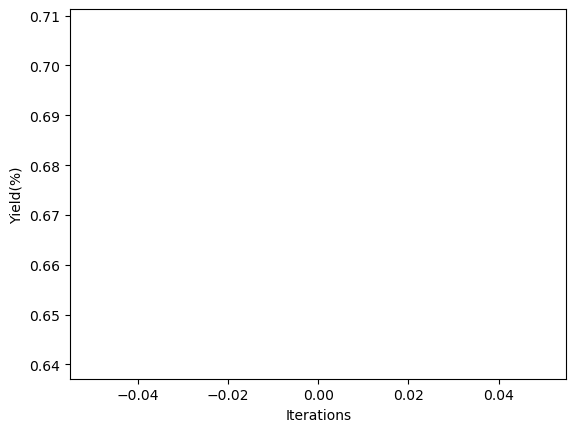

In [ ]:
optim.plot_yield()

## Get all the parameter values

### This can be stored in a file for later analysis or used to find the best parameter value depending upon a condition. For e.g. the values that give a minimum error.

In [ ]:
yields= []
final_params=[]

final_t50 = []
final_t85 = []
final_t95 = []
final_t99 = []

for i in range(len(optim.final_yields)):
    yields.append(optim.final_yields[i].item())
    final_params.append(optim.final_solns[i].numpy())
    
    #Storing the different time points it reaches a particular yield threshold
    if type(optim.final_t85[i])==int:
        final_t85.append(1) 
    else:
        final_t85.append(optim.final_t85[i].item()) 
    if type(optim.final_t95[i])==int:
        final_t95.append(1)
    else:
        final_t95.append(optim.final_t95[i].item())


final_yield_arr = np.array(yields)
final_param_arr = np.array(final_params)
final_t85 = np.array(final_t85)
final_t95 = np.array(final_t95)

### Plotting the ratio of ktri vs kdim

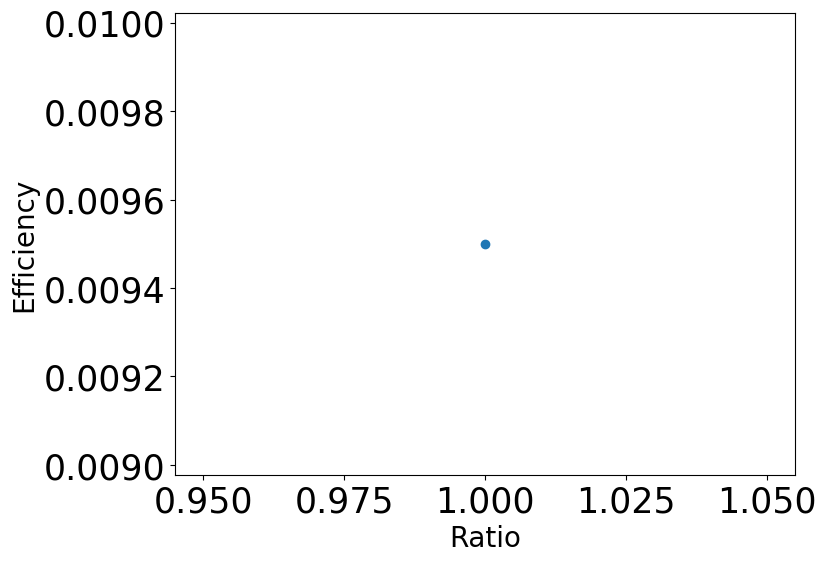

In [ ]:
import matplotlib.pyplot as plt

mask_r = final_yield_arr > 0.5

#Calculate the ratio
ratio = final_param_arr[:,1]/final_param_arr[:,0]

#Normalize the time scale (t = t*conc*max_rate)
conc=vec_rn.initial_copies[0].item()
scale_time = final_t95[mask_r]*conc*np.max(final_param_arr[mask_r],axis=1)
#Calculate the y_per_time
y_per_time = 0.95/scale_time

fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ratio,y_per_time,linestyle='',marker='o')
ax.set_ylabel("Efficiency",fontsize=20)
ax.set_xlabel("Ratio",fontsize=20)
ax.tick_params(labelsize=25)


In [ ]:
max_indx = np.argmax(y_per_time)
max_ratio = ratio[max_indx]
max_rates = final_param_arr[max_indx]
print("Ratio with maximum efficiency: ",max_ratio)

reaction_rates = np.zeros(rn._rxn_count)
counter=0
for cls,uids in vec_rn.rxn_class.items():
    for rid in uids:
        reaction_rates[rid]=max_rates[counter]
    counter+=1

print("Optimal Rates: ",list(reaction_rates))


Ratio with maximum efficiency:  1.0
Optimal Rates:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
import pandas as pd
print(pd.__version__)

1.2.3
